<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [133]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import statsmodels.stats.api as sms

import pylab as plt
import seaborn as sns

%matplotlib inline



In [134]:
# datos
df2= pd.read_csv('data/cookie_cats.csv')
df=df2.copy()
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [135]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [136]:
pd.crosstab(df.version, df.retention_1) #crosstab devuelve una tabla resultante de cruzar 2 o mas campos de df.sumatorio

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


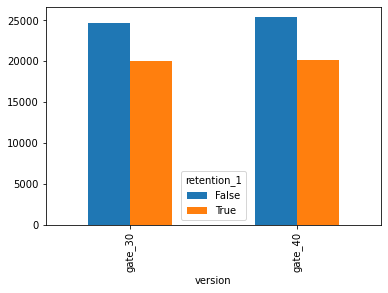

In [137]:
pd.crosstab(df.version, df.retention_1).plot(kind='bar');

In [138]:
df.version.value_counts() #necesito el total para establecer la muestra. Cogemos el minimo porque tiene q ser igual


gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [139]:
df.groupby('version').retention_1.sum() #aqui me daría solo los verdaderos que es lo que puede sumar. NO INTERESA AHORA

version
gate_30    20034
gate_40    20119
Name: retention_1, dtype: int64

In [140]:
df.userid.duplicated().sum() #nos dice si hay duplicados en el id, como abajo, pero abajo los hubiera borrado

0

In [141]:
df.drop_duplicates().value_counts() #confirmamos si hay duplicados, si hubiera los borraba, como no hay, devuelve datos

userid   version  sum_gamerounds  retention_1  retention_7
116      gate_30  3               False        False          1
6632278  gate_40  4               False        False          1
6658202  gate_40  9               False        False          1
6658194  gate_40  1               False        False          1
6658134  gate_40  112             True         False          1
                                                             ..
3347358  gate_40  0               False        False          1
3347337  gate_40  3               False        False          1
3346992  gate_40  185             True         False          1
3346979  gate_30  38              True         True           1
9999861  gate_40  16              False        False          1
Length: 90189, dtype: int64

In [142]:
# muestreo
control = df[df.version =='gate_30'].sample(n=44700, random_state=42) #random state es para que siempre coja los mismo id 
                                                                #(es para el ejerc para no ejecturae y que cambie
                                                                #en la realidad no se hace)

tratamiento = df[df.version=='gate_40'].sample(n=44700, random_state=42)

ab_test = pd.concat([control, tratamiento], axis=0)  #crea un df con contro y tratamiento

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,6531033,gate_30,35,False,False
1,8003009,gate_30,4,False,False
2,5566807,gate_30,23,True,False
3,64235,gate_30,1,False,False
4,6210551,gate_30,7,False,False


In [143]:
#Visualizacion
tasas_conversion=ab_test.groupby('version')['retention_1']  



#std=lambda x: np.std(x, ddof=0)    # averigua el std con lambda para que no se nos olvide, es lo mismo np.std



tasas_conversion=tasas_conversion.agg([np.mean, np.std])
tasas_conversion.columns=['conversion_rate', 'std']   #comprobamos la conversion y vemos que la web antigua ni llega a lo que había dicho


tasas_conversion.style.format('{:.3f}') 

,conversion_rate,std
version,,
gate_30,0.448,0.497
gate_40,0.443,0.497


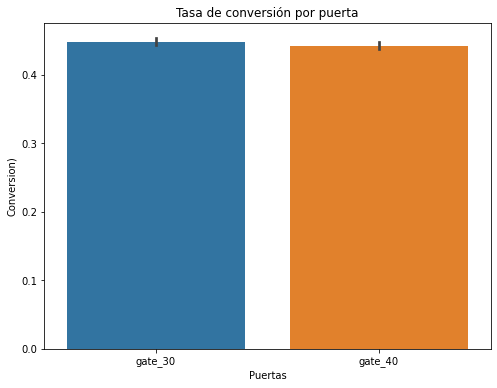

In [144]:
plt.figure(figsize=(8,6))   #NO ENSEÑA NADA, NO SIRVE PA NA

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_1'])

#plt.ylim(0, 0.17)
plt.title('Tasa de conversión por puerta')
plt.xlabel('Puertas')
plt.ylabel('Conversion)');

In [145]:
# testeo para retention_1

control_res=ab_test[ab_test.version=='gate_30']['retention_1']

trat_res=ab_test[ab_test.version=='gate_40']['retention_1'] 
control_res

0        False
1        False
2         True
3        False
4        False
         ...  
44695     True
44696     True
44697    False
44698    False
44699    False
Name: retention_1, Length: 44700, dtype: bool

In [146]:
observaciones = [44700, 44700]  #ES EL COUNT DE LA MUESTRA
observaciones


[44700, 44700]

In [147]:
conversiones=[control_res.sum(), trat_res.sum()]  # conversiones por grupo. Suma lo True
conversiones

[20034, 19783]

In [148]:
ab_test.groupby('version').retention_1.sum()  #TAMBIEN SE PUEDE HACER ASI

version
gate_30    20034
gate_40    19783
Name: retention_1, dtype: int64

In [149]:
z_score, p_valor = proportions_ztest(conversiones, nobs=observaciones) #DEVUELVE ESTADISTICA Y PROBABILIDAD
p_valor

0.09121036470055781

In [150]:
z_score

1.6890473061671334

In [151]:
# intervalos de confianza
(control_lower, tratamiento_lower), (control_upper, tratamiento_upper) = proportion_confint(conversiones, 
                                                                            nobs=observaciones,
                                                                            alpha=0.05)
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_lower:.3f}, {control_upper:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_lower:.3f}, {tratamiento_upper:.3f}]')

z-score: 1.69
p-valor: 0.091
intervalo conf 95% para grupo control: [0.444, 0.453]
intervalo conf 95% para grupo tratamiento: [0.438, 0.447]


In [152]:
# testeo para retention_7
pd.crosstab(df.version, df.retention_7)

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


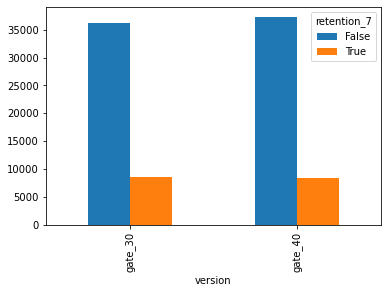

In [153]:
pd.crosstab(df.version, df.retention_7).plot(kind='bar');

In [154]:
#Visualizacion
tasas_conversion=ab_test.groupby('version')['retention_7']  



#std=lambda x: np.std(x, ddof=0)    # averigua el std con lambda para que no se nos olvide, es lo mismo np.std



tasas_conversion=tasas_conversion.agg([np.mean, np.std])
tasas_conversion.columns=['conversion_rate', 'std']   #comprobamos la conversion y vemos que la web antigua ni llega a lo que había dicho


tasas_conversion.style.format('{:.3f}') 

,conversion_rate,std
version,,
gate_30,0.190,0.392
gate_40,0.182,0.386


In [155]:

control_res=ab_test[ab_test.version=='gate_30']['retention_7']

trat_res=ab_test[ab_test.version=='gate_40']['retention_7'] 
trat_res


44700    False
44701    False
44702    False
44703    False
44704    False
         ...  
89395    False
89396    False
89397    False
89398    False
89399     True
Name: retention_7, Length: 44700, dtype: bool

In [156]:
observaciones= [44700, 44700]
conversiones=[control_res.sum(), trat_res.sum()]  # conversiones por grupo. Suma lo True
conversiones

[8502, 8155]

In [157]:
z_score, p_valor = proportions_ztest(conversiones, nobs=observaciones)
p_valor, z_score

(0.002876808101694685, 2.9806037079284167)

In [158]:
# intervalos de confianza
(control_lower, tratamiento_lower), (control_upper, tratamiento_upper) = proportion_confint(conversiones, 
                                                                            nobs=observaciones,
                                                                            alpha=0.05)
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_lower:.3f}, {control_upper:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_lower:.3f}, {tratamiento_upper:.3f}]')

z-score: 2.98
p-valor: 0.003
intervalo conf 95% para grupo control: [0.187, 0.194]
intervalo conf 95% para grupo tratamiento: [0.179, 0.186]


In [ ]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.

'''los datos finales nos indican que la retención de 1 día es p-valor: 0.091 se encuentran por encima del 0.05 
del nivel de significancia como en la retención de 7 días la probabilidad de estadística  por lo que no hay datos 
que sugieran una mejora cambiando a gate_40. Los resultados del estduio a 7 días sugieren que podría modificarse a 
gate_40 con mejoras, el datos es tan tan pequeño que no da ninguna seguridad que el 
cambio suponga una meoría y cuánto. 
Por tanto recomendamos continuar con gate_30.
